In [1]:
# connect to kaggle api and download files (zip)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi({"username":"lefkats","key":"dc2daabaadb558088b0497af1befdd89"})
api.authenticate()
files = api.competition_download_files("Instacart-Market-Basket-Analysis")

In [9]:
# extract the main zip file
import zipfile
with zipfile.ZipFile('C:/Users/Λευτερης/Instacart-Market-Basket-Analysis.zip', 'r') as zip_ref:
    zip_ref.extractall('C:/Users/Λευτερης/desktop/instacart')

In [10]:
import os
working_directory = 'C:/Users/Λευτερης/desktop/instacart'
os.chdir(working_directory)
for file in os.listdir(working_directory):   # get the list of files
    if zipfile.is_zipfile(file): # if it is a zipfile, extract it
        with zipfile.ZipFile(file) as item: # treat the file as a zip
           item.extractall()  # extract it in the working directory

RESULTS ON VALIDATION SET
F1 Score:  0.3512132655757067 
Classification Report
                precision    recall  f1-score   support

         0.0       0.93      0.89      0.91   6116209
         1.0       0.30      0.43      0.35    663520

    accuracy                           0.85   6779729
   macro avg       0.62      0.66      0.63   6779729
weighted avg       0.87      0.85      0.86   6779729
 
Confusion Matrix
  [[5453548  662661]
 [ 381026  282494]]
                   importance
u_reordered_ratio    0.282392
p_reorder_ratio      0.203273
p_total_purchases    0.196178
uxp_reorder_ratio    0.129910
u_total_orders       0.106095
uxp_total_bought     0.082152
True


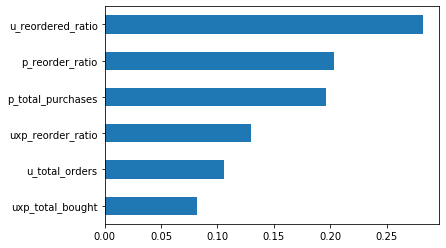

In [1]:
import pandas as pd
import gc                         
gc.enable()

orders = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/orders.csv' )
order_products_train = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/order_products__train.csv')
order_products_prior = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/order_products__prior.csv')
products = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/products.csv')
aisles = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/aisles.csv')
departments = pd.read_csv('C:/Users/Λευτερης/desktop/instacart/departments.csv')

orders.head()
order_products_train.head()
order_products_prior.head()
products.head()
aisles.head()
departments.head()

aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()
user = user.reset_index()
user.head()

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

user = user.merge(u_reorder, on='user_id', how='left')
del u_reorder
gc.collect()
user.head()

prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd.head()
prd = prd.reset_index()
prd.head()

p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

prd = prd.merge(p_reorder, on='product_id', how='left')
prd.head()
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()
uxp = uxp.reset_index()
uxp.head()

times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()


span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

del [times, first_order_no, span]
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

data = uxp.merge(user, on='user_id', how='left')
data.head()
data = data.merge(prd, on='product_id', how='left')
data.head()

del op, user, prd, uxp
gc.collect()

orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

data_train = data[data.eval_set=='train']
data_train.head()
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)
data_test = data[data.eval_set=='test']
data_test.head()
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()
data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(data_train.drop('reordered', axis=1), data_train.reordered, test_size=0.8, random_state=42)
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=42)
model = rfc.fit(X_train, y_train)
y_val_pred = (model.predict_proba(X_val)[:,1] >= 0.30).astype(int)
print("RESULTS ON VALIDATION SET\n====================")
print("F1 Score: ",f1_score(y_val, y_val_pred, average='binary'), "\n====================")
print("Classification Report\n ", classification_report(y_val, y_val_pred), "\n====================")
print("Confusion Matrix\n ", confusion_matrix(y_val, y_val_pred))
del [X_val, y_val]

feature_importances_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh')

test_pred = model.predict(data_test).astype(int)
test_pred = (model.predict_proba(data_test)[:,1] >= 0.30).astype(int)
test_pred[0:20]
data_test['prediction'] = test_pred
data_test.head(10)

final = data_test.reset_index()
final = final[['product_id', 'user_id', 'prediction']]
gc.collect()
final.head()

orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()
final = final.merge(orders_test, on='user_id', how='left')
final.head()
final = final.drop('user_id', axis=1)
final['product_id'] = final.product_id.astype(int)
del orders
del orders_test
gc.collect()
final.head()

d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()
d

sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.head()
sub.shape[0]
print(sub.shape[0]==75000)
sub.to_csv('C:/Users/Λευτερης/desktop/sub.csv', index=False)

In [16]:
api.competition_submit("C:/Users/Λευτερης/desktop/sub.csv", "my submission message", "Instacart-Market-Basket-Analysis")

100%|██████████████████████████████████████████████████████████████████████████████| 4.37M/4.37M [00:19<00:00, 232kB/s]


Successfully submitted to Instacart Market Basket Analysis